In [34]:
import numpy as np
from scipy.stats import multivariate_normal


class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihood = None
        self.iter_count = 0

    def initialise_parameters(self, X):
        n_samples, n_features = X.shape
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        self.covariances = [np.eye(n_features)] * self.n_components

        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):

        n_samples, n_features = X.shape
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):

            probability_k = multivariate_normal.pdf(
                x=X, mean=self.means[k], cov=self.covariances[k] + 1e-6*np.eye(n_features))
            responsibilities[:, k] = self.weights[k] * probability_k

        numerator = responsibilities
        denominator = np.sum(responsibilities,
                             axis=1, keepdims=True) + 1e-14

        responsibilities /= denominator

        return responsibilities, numerator

    def m_step(self, X, responsibilities):

        n_samples, n_features = X.shape
        total_responsibilities = np.sum(responsibilities, axis=0)

        for k in range(self.n_components):

            self.means[k] = np.sum(
                X * responsibilities[:, k, np.newaxis], axis=0) / total_responsibilities[k]

            diff = X - self.means[k]
            self.covariances[k] = (
                responsibilities[:, k, np.newaxis] * diff).T @ diff / total_responsibilities[k]
            self.covariances[k] += 1e-6*np.eye(n_features)

            self.weights[k] = total_responsibilities[k] / n_samples

    def fit(self, X):
        self.initialise_parameters(X)

        prev_log_likelihood = -np.inf
        for iteration in range(self.max_iter):
            responsibilities, numerator = self.e_step(X)
            self.m_step(X, responsibilities)
            self.iter_count += 1
            log_likelihood = np.sum(np.log(np.sum(numerator, axis=1)+1e-16))
            self.log_likelihood = log_likelihood
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break

            prev_log_likelihood = log_likelihood

    def get_parameters(self):
        return self.means, self.covariances, self.weights

    def get_log_likelihood(self):
        return self.log_likelihood

    def get_iteration_count(self):
        return self.iter_count

    def bic(self, X):
        n_samples = X.shape[0]
        return -2*self.log_likelihood*self.n_components*np.log(n_samples)

    def aic(self, X):
        n_samples = X.shape[0]
        return (-2/n_samples)*self.log_likelihood*(2*self.n_components/n_samples)

    def predict(self, X):
        responsibilities = self.e_step(X)[0]
        return responsibilities, np.argmax(responsibilities, axis=1)


In [35]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')
X = data.iloc[:, 1:]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm = GMM(n_components=4, max_iter=100, tol=1e-9)
gmm.fit(X_scaled)
membership_values = gmm.predict(X_scaled)[1]
responsibilities = gmm.predict(X_scaled)[0]
print(membership_values)


[0 2 0 ... 0 2 0]


In [36]:
print(gmm.get_log_likelihood())
print(gmm.get_iteration_count())


-1.1511925520863948e-05
15


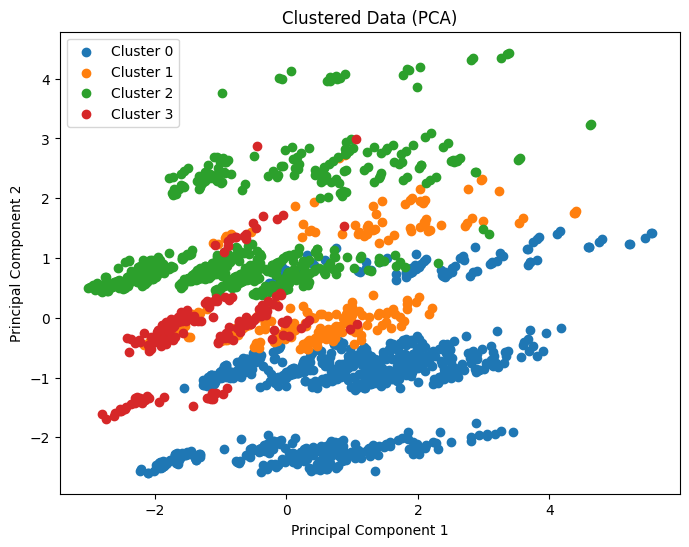

Silhouette Score: 0.18526333056924027
Cluster 0 Mean: [-0.91739884 -0.99302433  0.27112644 -0.41340741  0.21807227  0.18345643
  0.2930841 ]
Cluster 0 Covariance Matrix: [[ 1.66058317e-28  9.30499190e-29  1.82924268e-30  8.70719515e-29
   2.68288926e-30 -7.92671827e-30 -3.10971255e-29]
 [ 9.30499190e-29  5.21400408e-29  1.24998250e-30  5.01669805e-29
   1.34144463e-30 -4.39018243e-30 -1.39022444e-29]
 [ 1.82924268e-30  1.24998250e-30  9.67295129e-01  8.56415927e-01
   3.06160904e-01  1.15303836e-01  8.45909137e-02]
 [ 8.70719515e-29  5.01669805e-29  8.56415927e-01  1.00593365e+00
   2.66634433e-01  1.14856046e-01  5.95365560e-02]
 [ 2.68288926e-30  1.34144463e-30  3.06160904e-01  2.66634433e-01
   1.10887431e+00  7.12203141e-01  5.10707916e-01]
 [-7.92671827e-30 -4.39018243e-30  1.15303836e-01  1.14856046e-01
   7.12203141e-01  1.05977494e+00  6.04605564e-01]
 [-3.10971255e-29 -1.39022444e-29  8.45909137e-02  5.95365560e-02
   5.10707916e-01  6.04605564e-01  1.04426357e+00]]
Cluster 1 

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
unique_clusters = np.unique(membership_values)
for cluster_label in unique_clusters:
    cluster_mask = (membership_values == cluster_label)
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clustered Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

silhouette_avg = silhouette_score(X_scaled, membership_values)
print(f'Silhouette Score: {silhouette_avg}')

for cluster_label in unique_clusters:
    cluster_mask = (membership_values == cluster_label)
    cluster_data = X_scaled[cluster_mask]
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_covariance = np.cov(cluster_data, rowvar=False)
    print(f'Cluster {cluster_label} Mean: {cluster_mean}')
    print(f'Cluster {cluster_label} Covariance Matrix: {cluster_covariance}')


In [42]:
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans

wine = load_wine()
X = wine.data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)

gmm_bic = []
gmm_aic = []
for n_components in range(2, 6):
    gmm = GMM(n_components=n_components, max_iter=1000, tol=1e-9)
    gmm.fit(X_pca)
    gmm_labels = gmm.predict(X_pca)[1]
    gmm_bic.append(gmm.bic(X_pca))
    gmm_aic.append(gmm.aic(X_pca))
optimal_k = gmm_bic.index(min(gmm_bic)) + 2
gmm = GMM(n_components=optimal_k, max_iter=1000, tol=1e-9)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)[1]
gmm_silhouette = silhouette_score(X_pca, gmm_labels)


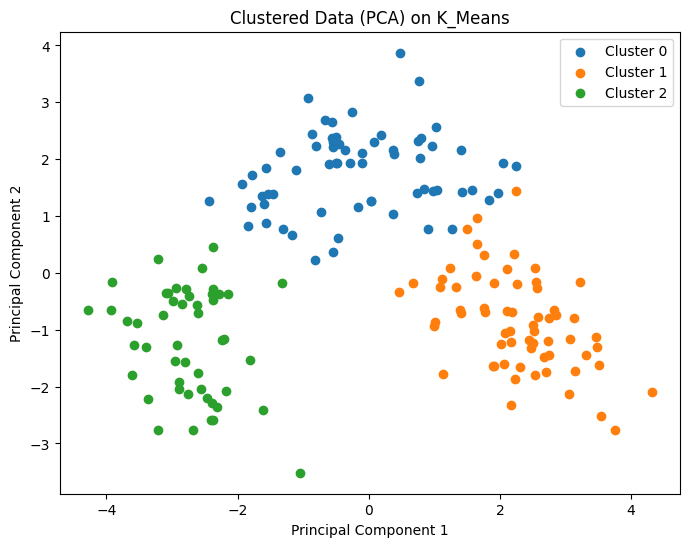

In [43]:
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(kmeans_labels)
for cluster_label in unique_clusters:
    cluster_mask = (kmeans_labels == cluster_label)
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clustered Data (PCA) on K_Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


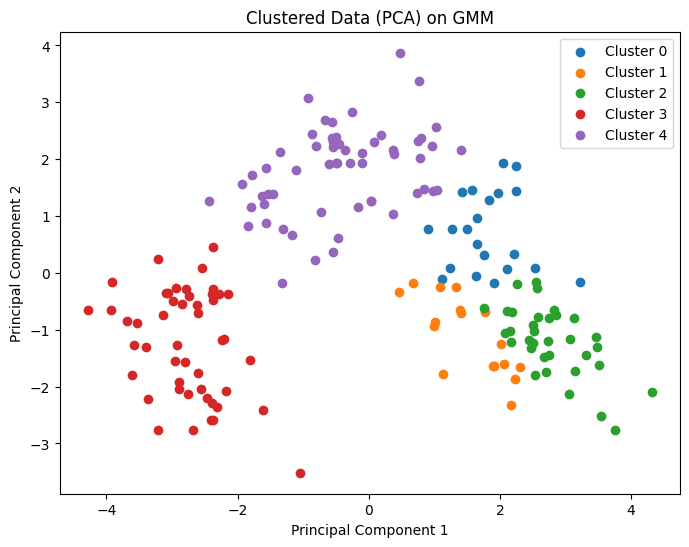

In [44]:
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(gmm_labels)
for cluster_label in unique_clusters:
    cluster_mask = (gmm_labels == cluster_label)
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clustered Data (PCA) on GMM')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
